# EDM Queries

This notebook contains a few useful queries to the sandbox that I've managed to come up with.

In [21]:
import getpass
import urllib.parse
import pandas as pd

edm_address = getpass.getpass(prompt='EDM server address: ')

print('\nEDM login information')
edm_name = getpass.getpass(prompt='Username: ')
edm_password = getpass.getpass(prompt='Password: ')
edm_password = urllib.parse.quote(edm_password)

%load_ext sql
%sql postgresql://$edm_name:$edm_password@$edm_address/edm
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False

# Delete the credential variables for security purpose.
del edm_name, edm_password

EDM server address: ········

EDM login information
Username: ········
Password: ········
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [15]:
%reload_ext sql

This queries collects all meters and their associated transformer.

In [2]:
%%sql

SELECT geds.grid_element_data_source_id,  
        geds.grid_element_id,
        meta_data.value
FROM grid_element_data_source geds
JOIN grid_element ge ON geds.grid_element_id = ge.grid_element_id
JOIN json_each_text(ge.meta::json) AS meta_data
    ON true
WHERE geds.grid_element_id IN(
    SELECT grid_element_id
    FROM grid_element
    WHERE type = 'Meter') AND meta_data.key = 'parent_transformer_id';

grid_element_data_source_id,grid_element_id,value
c1f0a432-771e-46fc-aa84-efef5dd84c5e,m_1,transformer_16
0d019e82-de4a-4115-9c64-e8288ade79e9,m_2,transformer_16
adc65088-66bd-49ba-9deb-a42e538a50a6,m_3,transformer_16
d351f2b5-3326-45a8-a259-9eaf439da74a,m_4,transformer_26
b254dc80-07a9-464f-aedf-407450c07a82,m_5,transformer_26
3b61660d-9b7a-442b-ae54-2ca1039f98f3,m_6,transformer_26
a93a4af1-5c51-4ef8-b9d4-355a92a3dad1,m_7,transformer_36
a0eadf9f-7858-4db9-9a38-0f43374c5763,m_8,transformer_36
66e8132c-d413-486b-82ca-e02fdf6c866a,m_9,transformer_36
4629171a-418d-46d3-90fe-b28a357ebf7e,m_10,transformer_36


On this small dataset, this is fine. If there were a lot of substations and thousands/millions of meters, this would be terrible. In that case, we should limit the query based on substation. That would require us to:
- specify a substation name
- get all transformers downstream of the substation
- get all meters downstream of those transformers.

Let's build this up bit by bit.

In [11]:
working_grid_id = 'awefice'

In [3]:
%%sql

SELECT grid_element_id
FROM grid_element
WHERE type = 'Substation';

grid_element_id
enc_1


In [13]:
substation_id = 'enc_1'

In [14]:
%%sql

SELECT *
FROM grid_get_downstream(:working_grid_id, :substation_id ,False)

grid_id,grid_element_id,type,customer_type,phases,is_underground,is_producer,is_consumer,is_switchable,switch_is_open,terminal1_cn,terminal2_cn,power_flow_direction,upstream_grid_element_id,geometry,meta


In [16]:
%%sql

SELECT *
FROM grid_get_downstream('awefice', 'enc_1', False)

grid_id,grid_element_id,type,customer_type,phases,is_underground,is_producer,is_consumer,is_switchable,switch_is_open,terminal1_cn,terminal2_cn,power_flow_direction,upstream_grid_element_id,geometry,meta


Well, that's not ideal.

So, this approach doesn't work. Well, we can still specify a list of transformers that we're interested. Let's see if we can get the list syntax working first.

In [21]:
transformers = tuple(['transformer_16', 'transformer_31', 'transformer_63'])

In [22]:
%%sql

SELECT *
FROM grid_element
WHERE grid_element_id IN :transformers

grid_id,grid_element_id,type,customer_type,phases,is_underground,is_producer,is_consumer,is_switchable,switch_is_open,terminal1_cn,terminal2_cn,power_flow_direction,upstream_grid_element_id,geometry,meta
awefice,transformer_16,Transformer,transformer,A,False,False,False,False,None,con_32,con_34,both,None,0101000020E6100000FBE59315C3C65EC00CF5264C39A24840,"{'name': 'tr_16', 'label': 'tr_16', 'latitude': 49.26737358, 'load_loss': 240, 'longitude': -123.105657, 'mv_feeder': None, 'ownership': 'utility', 'make_model': None, 'rating_kva': 5, 'enclosure_id': None, 'no_load_loss': 47, 'voltage_level': 'MV/LV', 'commission_date': '1989-01-01', 'primary_voltage': 12500, 'maintenance_type': 'oil', 'manufacture_date': None, 'installation_type': 'pole', 'secondary_voltage': 120, 'hvmv_parent_element': None, 'is_operation_status': True, 'parent_transformer_id': None, 'winding_configuration': None}"
awefice,transformer_31,Transformer,transformer,B,False,False,False,False,None,con_84,con_86,1to2,switchable_element_30,0101000020E61000002B508BC1C3C65EC09C3C3CB62BA24840,"{'name': 'tr_31', 'label': 'tr_31', 'latitude': 49.26695898, 'load_loss': 600, 'longitude': -123.105698, 'mv_feeder': None, 'ownership': 'utility', 'make_model': None, 'rating_kva': 30, 'enclosure_id': None, 'no_load_loss': 99, 'voltage_level': 'MV/LV', 'commission_date': '1979-01-01', 'primary_voltage': 12500, 'maintenance_type': 'oil', 'manufacture_date': None, 'installation_type': 'pole', 'secondary_voltage': 120, 'hvmv_parent_element': None, 'is_operation_status': True, 'parent_transformer_id': None, 'winding_configuration': None}"
awefice,transformer_63,Transformer,transformer,ABC,False,False,False,False,None,con_170,con_171,both,None,0101000020E61000009885764EB3C65EC04A8D3B6B58A24840,"{'name': 'tr_63', 'label': 'tr_63', 'latitude': 49.26832333, 'load_loss': 4622, 'longitude': -123.104694, 'mv_feeder': None, 'ownership': 'utility', 'make_model': None, 'rating_kva': 300, 'enclosure_id': None, 'no_load_loss': 544, 'voltage_level': 'MV/LV', 'commission_date': '1985-01-01', 'primary_voltage': 12500, 'maintenance_type': 'dry', 'manufacture_date': None, 'installation_type': 'station', 'secondary_voltage': 400, 'hvmv_parent_element': None, 'is_operation_status': True, 'parent_transformer_id': None, 'winding_configuration': None}"


If our goal is to generate the downstream meters for a selection of transformers, we could do it like this:
- create list of transformers as a python list
- iterate over that list, generating a view for each transformer using a consistent format
- convert each of those views to a dataframe
- then concatenate those dataframes

This does mean that we'll *probably* have to grab timeseries information for each of the meters programmatically and concatenate, rather than just doing it with SQL.

In [8]:
%%sql 

SELECT *
FROM get_function_documentation()
WHERE function_name = 'ts_data_source_select';

function_name,function_args,function_result,description
ts_data_source_select,"id uuid, metric_key text, timerange tstzrange DEFAULT NULL::tstzrange",SETOF edm.ts_data_source_double,"Returns the set of time series data in time_series_double format for the given data source id, metric, and time range."


In [9]:
transformer_id = 'transformer_16'

In [30]:
%reload_ext sql

In [50]:
%%sql

SELECT :transformer_id AS transformer, tdss.timestamp, metric_key, SUM(tdss.value) AS power
FROM grid_get_downstream('awefice', :transformer_id) ggd
JOIN grid_element_data_source geds
    ON geds.grid_id = ggd.grid_id
    AND geds.grid_element_id = ggd.grid_element_id
JOIN UNNEST(geds.metrics::TEXT[]) metric_key
    ON true
JOIN ts_data_source_select(geds.grid_element_data_source_id, metric_key, '[2021-01-01, 2021-01-02]') tdss
    ON true
WHERE ggd.grid_id = 'awefice'
    AND ggd.type = 'Meter'
    AND metric_key = 'kWh'
GROUP BY metric_key, tdss.timestamp
ORDER BY 1, 2
LIMIT 20;

transformer,timestamp,metric_key,power
transformer_16,2021-01-01 08:00:00+00:00,kWh,5.676
transformer_16,2021-01-01 09:00:00+00:00,kWh,5.418
transformer_16,2021-01-01 10:00:00+00:00,kWh,5.498
transformer_16,2021-01-01 11:00:00+00:00,kWh,5.216
transformer_16,2021-01-01 12:00:00+00:00,kWh,5.784
transformer_16,2021-01-01 13:00:00+00:00,kWh,6.341
transformer_16,2021-01-01 14:00:00+00:00,kWh,6.737
transformer_16,2021-01-01 15:00:00+00:00,kWh,5.47
transformer_16,2021-01-01 16:00:00+00:00,kWh,5.071
transformer_16,2021-01-01 17:00:00+00:00,kWh,5.594


In [62]:
%%sql

SELECT tdss.timestamp, geds.grid_element_id, metric_key, tdss.value
FROM grid_get_downstream('awefice', :transformer_id) ggd
JOIN grid_element_data_source geds
    ON geds.grid_id = ggd.grid_id
    AND geds.grid_element_id = ggd.grid_element_id
JOIN UNNEST(geds.metrics::TEXT[]) metric_key
    ON true
JOIN ts_data_source_select(geds.grid_element_data_source_id, metric_key, '[2021-01-01, 2021-01-02]') tdss
    ON true
WHERE ggd.grid_id = 'awefice'
    AND ggd.type = 'Meter'
ORDER BY 1, 3, 2
LIMIT 20;

timestamp,grid_element_id,metric_key,value
2021-01-01 08:00:00+00:00,m_1,kWh,1.827
2021-01-01 08:00:00+00:00,m_2,kWh,2.034
2021-01-01 08:00:00+00:00,m_3,kWh,1.815
2021-01-01 08:00:00+00:00,m_1,V,119.566
2021-01-01 08:00:00+00:00,m_2,V,119.114
2021-01-01 08:00:00+00:00,m_3,V,119.214
2021-01-01 09:00:00+00:00,m_1,kWh,1.737
2021-01-01 09:00:00+00:00,m_2,kWh,1.947
2021-01-01 09:00:00+00:00,m_3,kWh,1.734
2021-01-01 09:00:00+00:00,m_1,V,119.237


In [13]:
%%sql

SELECT tdss.timestamp, geds.grid_element_id, 
    MAX(CASE WHEN metric_key = 'V' THEN tdss.value END) AS V,
    MAX(CASE When metric_key = 'kWh' THEN tdss.value END) AS kWh
FROM grid_get_downstream('awefice', :transformer_id) ggd
JOIN grid_element_data_source geds
    ON geds.grid_id = ggd.grid_id
    AND geds.grid_element_id = ggd.grid_element_id
JOIN UNNEST(geds.metrics::TEXT[]) metric_key
    ON true
JOIN ts_data_source_select(geds.grid_element_data_source_id, metric_key, '[2022-07-19, 2022-07-20]') tdss
    ON true
WHERE ggd.grid_id = 'awefice'
    AND ggd.type = 'Meter'
GROUP BY tdss.timestamp, geds.grid_element_id
ORDER BY 1, 2
LIMIT 20;

timestamp,grid_element_id,v,kwh
2022-07-19 00:00:00+00:00,m_1,121.468,0.547
2022-07-19 00:00:00+00:00,m_2,120.877,0.595
2022-07-19 00:00:00+00:00,m_3,120.613,0.539
2022-07-19 01:00:00+00:00,m_1,121.606,0.604
2022-07-19 01:00:00+00:00,m_2,120.761,0.663
2022-07-19 01:00:00+00:00,m_3,120.1,0.592
2022-07-19 02:00:00+00:00,m_1,121.211,0.599
2022-07-19 02:00:00+00:00,m_2,120.742,0.668
2022-07-19 02:00:00+00:00,m_3,122.021,0.6
2022-07-19 03:00:00+00:00,m_1,120.656,0.709


In [92]:
%%sql

SELECT :transformer_id AS transformer, consol.timestamp, SUM(consol.kWh) AS power, consol.V AS voltage
FROM (SELECT tdss.timestamp, geds.grid_element_id, 
        MAX(CASE WHEN metric_key = 'V' THEN tdss.value END) AS V,
        MAX(CASE When metric_key = 'kWh' THEN tdss.value END) AS kWh
    FROM grid_get_downstream('awefice', :transformer_id) ggd
    JOIN grid_element_data_source geds
        ON geds.grid_id = ggd.grid_id
        AND geds.grid_element_id = ggd.grid_element_id
    JOIN UNNEST(geds.metrics::TEXT[]) metric_key
        ON true
    JOIN ts_data_source_select(geds.grid_element_data_source_id, metric_key, '[2021-01-01, 2021-01-02]') tdss
        ON true
    WHERE ggd.grid_id = 'awefice'
        AND ggd.type = 'Meter'
    GROUP BY tdss.timestamp, geds.grid_element_id) AS consol
GROUP BY consol.timestamp, consol.V
ORDER BY 1, 2
LIMIT 20;

transformer,timestamp,power,voltage
transformer_16,2021-01-01 08:00:00+00:00,1.815,119.214
transformer_16,2021-01-01 08:00:00+00:00,1.827,119.566
transformer_16,2021-01-01 08:00:00+00:00,2.034,119.114
transformer_16,2021-01-01 09:00:00+00:00,1.737,119.237
transformer_16,2021-01-01 09:00:00+00:00,1.734,118.803
transformer_16,2021-01-01 09:00:00+00:00,1.947,119.643
transformer_16,2021-01-01 10:00:00+00:00,1.766,118.639
transformer_16,2021-01-01 10:00:00+00:00,1.758,119.605
transformer_16,2021-01-01 10:00:00+00:00,1.974,119.528
transformer_16,2021-01-01 11:00:00+00:00,1.87,119.591


TODO:
- aggregate load from those statistics. Right now, the group by isn't working because voltage isn't constant.

So, we can do this for a single transformer.

Can we now do it for all of the transformers that are affected? I.e., find load on this transformer, and all transformers that are upstream of it.

Let's start by getting a list of all transformers upstream of this one. In this case, the expected answer is just transformer_2.

In [13]:
%%sql

upstream_transformers_sql << SELECT grid_element_id
FROM grid_get_sources('awefice', :transformer_id, true)
WHERE type = 'Transformer' 
    AND grid_element_id != :transformer_id

Returning data to local variable upstream_transformers_sql


In this case, since there's only the one transformer upstream, we have the top node of our tree. We can then take that, get all of the downstream transformers from that upstream transformer. We won't need to store those for our analysis, but we will have to be able to aggregate load from those downstream transformers to the root transformer.

Let's get a dataframe with load for each downstream transformer.

In [ ]:
def find_root_transformer(transformer_id):
    '''Takes a grid element and finds the root transformer upstream of it.'''
    
            Para
    
    upstream_transformers_sql = %sql    SELECT grid_element_id \
                                        FROM grid_get_sources('awefice', :transformer_id, false) \
                                        WHERE type = 'Transformer';
    
    

    if upstream_transformers_sql.DataFrame().shape[0] = 0:
        return transformer_id
    else:
        return find_root_transformer(upstream_transformers_sql.DataFrame().iloc[0,0])

In [45]:
def agg(meters, transformer_data, start_date, end_date):
    '''Takes a list of grid elements and aggregates their load.
    
                 Parameters:
                         meters (List of strings): list of grid_element_ids of all meters to aggregate
                         transformer_data (List of DataFrames): list of pandas databases containing the aggregated 
                                                                     data for connected transformers
                                                                     
                                                                     Dataframes will contain 3 columns:
                                                                         timestamp
                                                                         load in kWh
                                                                         
                         start_date (String): start date of time series range
                         end_date (String): end date of time series range
    
    '''
    
    meter_data = []
    
    timestamp_data = None
    
    for meter in meters:
        meter_data_sql = %sql SELECT tdss.timestamp AS timestamp, geds.grid_element_id AS g_id, \
                                    MAX(CASE WHEN metric_key = 'V' THEN tdss.value END) AS V, \
                                    MAX(CASE When metric_key = 'kWh' THEN tdss.value END) AS kWh \
                                FROM grid_element ge \
                                JOIN grid_element_data_source geds \
                                    ON geds.grid_id = ge.grid_id \
                                    AND geds.grid_element_id = ge.grid_element_id \
                                JOIN UNNEST(geds.metrics::TEXT[]) metric_key \
                                    ON true \
                                JOIN ts_data_source_select(geds.grid_element_data_source_id, metric_key, '[{start_date}, {end_date}]') tdss \
                                    ON true \
                                WHERE ge.grid_id = 'awefice' \
                                    AND ge.type = 'Meter' \
                                    AND ge.grid_element_id = :meter \
                                GROUP BY tdss.timestamp, geds.grid_element_id \
                                ORDER BY 1, 2;
        
        
        this_meter = meter_data_sql.DataFrame()
            
        
        if timestamp_data is None:
            timestamp_data = pd.DataFrame(this_meter.timestamp)
        
        meter_kA = meter + 'kA'
        this_meter[meter_kA] = this_meter['kwh']/this_meter['v']
        this_meter.set_index('timestamp') 
            
        #remove all columns except for timestamp and current
        meter_data.append(this_meter[[meter_kA]])
        
    loads = timestamp_data.join(meter_data).set_index('timestamp')
    
    loads = loads.sum(axis = 1)
        
    return loads

In [46]:
agg(['m_1', 'm_2', 'm_3'], None, '2022-07-19', '2022-07-20')

timestamp
2022-07-19 00:00:00+00:00    0.013894
2022-07-19 01:00:00+00:00    0.015386
2022-07-19 02:00:00+00:00    0.015391
2022-07-19 03:00:00+00:00    0.018363
2022-07-19 04:00:00+00:00    0.019156
2022-07-19 05:00:00+00:00    0.015806
2022-07-19 06:00:00+00:00    0.012551
2022-07-19 07:00:00+00:00    0.010048
2022-07-19 08:00:00+00:00    0.007508
2022-07-19 09:00:00+00:00    0.006943
2022-07-19 10:00:00+00:00    0.006549
2022-07-19 11:00:00+00:00    0.007260
2022-07-19 12:00:00+00:00    0.008598
2022-07-19 13:00:00+00:00    0.009562
2022-07-19 14:00:00+00:00    0.010833
2022-07-19 15:00:00+00:00    0.011776
2022-07-19 16:00:00+00:00    0.012108
2022-07-19 17:00:00+00:00    0.012676
dtype: float64

In [58]:
def transformer_aggregate(transformer_id, start_date, end_date):
    ''' Takes transformer_id, returns dataframe with aggregated load time series for
        times between start_date and end_date.
    
                Parameters:
                        transformer_id (String): grid_element_id of transformer
                        start_date (String): start date of time series range
                        end_date (String): end date of time series range
                        upstream_transformers (bool): flag which determines whether to look at upstream
                                                        transformers
    
        Note, this function currently will not run. It depends 
    '''
    
    
    #First, collect all downstream transformers and aggregate on them.
    
    dt_sql = %sql   SELECT grid_element_id AS g_id\
                    FROM grid_get_downstream('awefice', :transformer_id, false) \
                    WHERE type = 'Transformer';
    
    downstream_transformer_data = []
    
    if dt_sql.DataFrame().shape[0] != 0:
    
        downstream_transformers = dt_sql.DataFrame()['g_id'].tolist()
    
        for transformer in downstream_transformers:
            downstream_transformer_data.append(transformer_aggregate(transformer, start_date, end_date))
    
    else:
        downstream_transformers = []
        
    #Next, collect all meters on this transformer and aggregate on them.
    
    #Problem: grid_get_downstream gets ALL meters downstream, not just those that are directly connected
    #    to this transformer. So, we'll need to iterate through all downstream transformers and remove those
    #    from our meter list.
    
    m_sql = %sql   SELECT grid_element_id \
                    FROM grid_get_downstream('awefice', :transformer_id, false) \
                    WHERE type = 'Meter';
    
    meters = m_sql.DataFrame().grid_element_id.tolist()
    
    meters_to_exclude = []
    
    for transformer in downstream_transformers:
        dt_m_sql = %sql  SELECT grid_element_id \
                            FROM grid_get_downstream('awefice', :transformer, false) \
                            WHERE type = 'Meter';
        
        meters_to_exclude = meters_to_exclude + dt_m_sql.DataFrame().grid_element_id.tolist()
        
    meters = [m for m in meters if m not in meters_to_exclude]
    
    
    return agg(meters, downstream_transformer_data, start_date, end_date)

In [59]:
transformer_aggregate('transformer_16', '2022-07-19', '2022-07-20')

timestamp
2022-07-19 00:00:00+00:00    0.013894
2022-07-19 01:00:00+00:00    0.015386
2022-07-19 02:00:00+00:00    0.015391
2022-07-19 03:00:00+00:00    0.018363
2022-07-19 04:00:00+00:00    0.019156
2022-07-19 05:00:00+00:00    0.015806
2022-07-19 06:00:00+00:00    0.012551
2022-07-19 07:00:00+00:00    0.010048
2022-07-19 08:00:00+00:00    0.007508
2022-07-19 09:00:00+00:00    0.006943
2022-07-19 10:00:00+00:00    0.006549
2022-07-19 11:00:00+00:00    0.007260
2022-07-19 12:00:00+00:00    0.008598
2022-07-19 13:00:00+00:00    0.009562
2022-07-19 14:00:00+00:00    0.010833
2022-07-19 15:00:00+00:00    0.011776
2022-07-19 16:00:00+00:00    0.012108
2022-07-19 17:00:00+00:00    0.012676
dtype: float64

### Visualization functions:

In [78]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
init_notebook_mode(connected=True)
cf.go_offline()


In [85]:
def plot_grid_element(g_id, start_date, end_date, target_metric):
    
    geds_id = %sql SELECT grid_element_data_source_id \
                        FROM grid_element_data_source \
                        WHERE grid_element_id = :g_id;
        
    geds_id = geds_id.DataFrame().grid_element_data_source_id.tolist()[0]
    
    
    grid_element_ts = %sql SELECT tdss.timestamp, geds.grid_element_id, metric_key, tdss.value  \
                                FROM grid_element ge \
                                JOIN grid_element_data_source geds \
                                    ON geds.grid_id = ge.grid_id \
                                    AND geds.grid_element_id = ge.grid_element_id \
                                JOIN UNNEST(geds.metrics::TEXT[]) metric_key \
                                    ON true \
                                JOIN ts_data_source_select(geds.grid_element_data_source_id, metric_key, '[{start_date}, {end_date}]') tdss \
                                    ON true \
                                WHERE ge.grid_id = 'awefice' \
                                    AND ge.type = 'Meter' \
                                    AND geds.grid_element_data_source_id = :geds_id \
                                ORDER BY 1, 2
    
    df = grid_element_ts.DataFrame()
    
    sns.lineplot(data = df[df.metric_key == target_metric], x = 'timestamp', y = 'value')

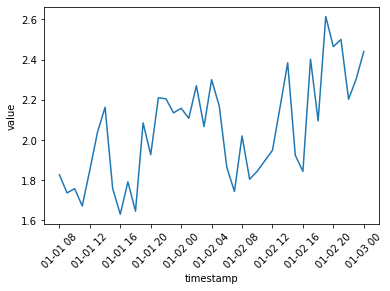

In [91]:
plot_grid_element('m_1', '2021-01-01', '2021-01-03', 'kWh')
plt.xticks(rotation=45)
plt.show()